In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import join, isfile, isdir
from glob import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from PIL import Image
sns.set()
from tqdm import tqdm
%matplotlib inline

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator



In [2]:
import sys, os, time, imageio 
import numpy as np, pandas as pd  

import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image 

import torch 
import torchvision.utils as vutils 
import torchvision.transforms as transforms 

from keras import models, layers, optimizers 
from keras.models import Sequential 
#from keras.preprocessing.image import array_to_img, img_to_array, load_img 

from tensorflow.keras.utils import array_to_img,img_to_array, load_img 

import tensorflow as tf

In [3]:
!nvidia-smi

Sat Apr 15 13:04:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#test_df = pd.read_csv("../input/nih-chest-xray-dataset/test.csv")
#test_df.head()
all_xray_df = pd.read_csv("../input/chestxray8-dataframe/train_df.csv")
all_xray_df.drop(['No Finding'], axis = 1, inplace = True)
all_xray_df.head()

data_dir1 = '../input/data/'
data_dir2 = '../input/chestxray8-dataframe/'
train_df = pd.read_csv(data_dir1 + 'Data_Entry_2017.csv')
image_label_map = pd.read_csv(data_dir2 + 'train_df.csv')
bad_labels = pd.read_csv(data_dir2 + 'cxr14_bad_labels.csv')

# Listing all the .png filepaths
image_paths = glob(data_dir1+'images_*/images/*.png')
print(f'Total image files found : {len(image_paths)}')
print(f'Total number of image labels: {image_label_map.shape[0]}')
print(f'Unique patients: {len(train_df["Patient ID"].unique())}')

image_label_map.drop(['No Finding'], axis = 1, inplace = True)
labels = image_label_map.columns[2:-1]
labels
image_label_map.shape

Total image files found : 112120
Total number of image labels: 111863
Unique patients: 30805


(111863, 17)

In [5]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [6]:
train_df.rename(columns={"Image Index": "Index"}, inplace = True)
image_label_map.rename(columns={"Image Index": "Index"}, inplace = True)
train_df = train_df[~train_df.Index.isin(bad_labels.Index)]
train_df.shape

Index =[]
for path in image_paths:
    Index.append(path.split('/')[5])
index_path_map = pd.DataFrame({'Index':Index, 'FilePath': image_paths})
index_path_map.head()

# Merge the absolute path of the images to the main dataframe
pd.merge(train_df, index_path_map, on='Index', how='left')

,Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,FilePath
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111858,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030801_001.png
111859,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030802_000.png
111860,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030803_000.png
111861,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030804_000.png


In [7]:
merge_df = pd.merge(train_df, index_path_map, on='Index', how='left')
merge_df.head()

,Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,FilePath
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png


In [8]:
merge_df['fl'] = merge_df['Finding Labels'].str.split("|")
merge_df.head()

,Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,FilePath,fl
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png,[Cardiomegaly]
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]"
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]"
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png,[No Finding]
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png,[Hernia]


In [9]:
def make(col):
    return col[0]

In [10]:
merge_df['f2'] = merge_df['fl'].apply(make)

In [11]:
new_df = merge_df[['f2','FilePath']]
new_df.head()

,f2,FilePath
0,Cardiomegaly,../input/data/images_001/images/00000001_000.png
1,Cardiomegaly,../input/data/images_001/images/00000001_001.png
2,Cardiomegaly,../input/data/images_001/images/00000001_002.png
3,No Finding,../input/data/images_001/images/00000002_000.png
4,Hernia,../input/data/images_001/images/00000003_000.png


In [12]:
new_df.shape

(111863, 2)

<AxesSubplot:ylabel='f2'>

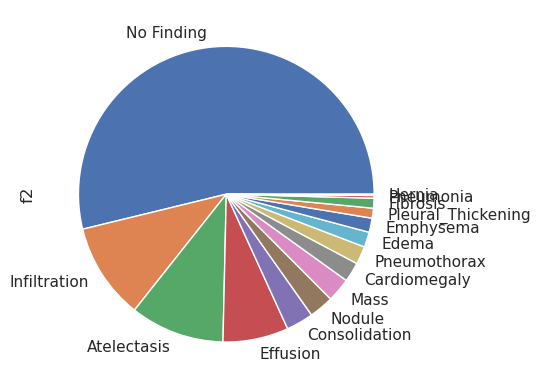

In [62]:
new_df['f2'].value_counts().plot(kind="pie")

In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the data into a Pandas dataframe

# Separate the features and target variable
X = new_df['FilePath']
y = new_df['f2']

# Perform stratified train-test split with 70% training data and 30% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [15]:
new_df1 = pd.DataFrame({'FilePath':X_train,'f2':y_train})

In [16]:
new_df1.head()

,FilePath,f2
68962,../input/data/images_008/images/00017064_002.png,No Finding
43304,../input/data/images_005/images/00011209_000.png,No Finding
7065,../input/data/images_002/images/00001872_011.png,No Finding
1094,../input/data/images_001/images/00000269_001.png,No Finding
6805,../input/data/images_002/images/00001836_011.png,Infiltration


In [17]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)

# **DENSNET-121 BEFORE CLASS IMBALANCE**

In [27]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # define parameters for data augmentation and preprocessing
# datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2) # if you want to split your data into train/validation sets

# # set the target size of the images
# img_size = (224, 224)

# # create a train generator
# train_generator = datagen.flow_from_dataframe(
#     dataframe=df,
#     x_col="FilePath",
#     y_col="f2",
#     target_size=img_size,
#     batch_size=32,
#     class_mode="categorical",
#     subset="training") # use the "training" subset for training

# # create a validation generator (optional)
# valid_generator = datagen.flow_from_dataframe(
#     dataframe=df,
#     x_col="FilePath",
#     y_col="f2",
#     target_size=img_size,
#     batch_size=32,
#     class_mode="categorical",
#     subset="validation") # use the "validation" subset for validation


In [28]:
model = tf.keras.applications.densenet.DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=15,
    classifier_activation='softmax'
)

In [29]:

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input

datagen = ImageDataGenerator()

batch_size = 32
generator = datagen.flow_from_dataframe(
dataframe = new_df1,
x_col = 'FilePath',
y_col = 'f2',
target_size = (224,224),
batch_size = batch_size,
class_mode = 'categorical',
shuffle = True)

Found 78304 validated image filenames belonging to 15 classes.


In [30]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
num_epochs = 30
step_per_epoch = len(new_df1)//batch_size
history = model.fit_generator(
generator = generator,
steps_per_epoch = step_per_epoch,
epochs = num_epochs)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
2447/2447 [==============================] - 2033s 831ms/step - loss: 1.6299 - accuracy: 0.5362
Epoch 2/30
2447/2447 [==============================] - 1957s 800ms/step - loss: 1.5888 - accuracy: 0.5390
Epoch 3/30
2447/2447 [==============================] - 2036s 832ms/step - loss: 1.5552 - accuracy: 0.5417
Epoch 4/30
2447/2447 [==============================] - 1972s 806ms/step - loss: 1.5230 - accuracy: 0.5437
Epoch 5/30
2447/2447 [==============================] - 2090s 854ms/step - loss: 1.4967 - accuracy: 0.5490
Epoch 6/30
2447/2447 [==============================] - 1954s 799ms/step - loss: 1.4742 - accuracy: 0.5498
Epoch 7/30
2447/2447 [==============================] - 1947s 796ms/step - loss: 1.4546 - accuracy: 0.5523
Epoch 8/30
2447/2447 [==============================] - 2042s 834ms/step - loss: 1.4370 - accuracy: 0.5545
Epoch 9/30
2447/2447 [==============================] - 1999s 817ms/step - loss: 1.4160 - accuracy: 0.5584
Epoch 10/30
2447/2447 [==============

In [1]:
y_pred = model.predict_generator(generator)

import numpy as np
y_pred_class = np.argmax(y_pred,axis=1)

NameError: name 'model' is not defined

In [23]:
score = model.evaluate_generator(generator)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


NameError: name 'scores' is not defined

In [24]:
print(score[1]*100)

54.374998807907104


In [72]:
model.compile(optimizer='adam', loss='softmax', metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    epochs=10,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples // valid_generator.batch_size)


Epoch 1/10


ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1083, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 240, in __call__
        self.build(y_pred)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 183, in build
        self._get_loss_object, self._losses
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 353, in _get_loss_object
        loss = losses_mod.get(loss)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 2663, in get
        return deserialize(identifier)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 2621, in deserialize
        printable_module_name="loss function",
    File "/opt/conda/lib/python3.7/site-packages/keras/saving/legacy/serialization.py", line 558, in deserialize_keras_object
        f"Unknown {printable_module_name}: '{object_name}'. "

    ValueError: Unknown loss function: 'softmax'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [ ]:
model.fit()

In [ ]:
from keras.preprocessing.image import I

# **DENSENET-121 After increasing the data through GAN**

In [18]:
hernia_gan_ip = glob('/kaggle/input/hernia-gan/generated_image_hernia*.png')
pneumonia_gan_ip = glob('/kaggle/input/pneumonia-gan/generated_image_pneumonia*.png')


In [19]:
new_df_gan = new_df

In [20]:
for i in range(len(pneumonia_gan_ip)):
    new_row = pd.DataFrame({'f2':'Pneumonia', 'FilePath':pneumonia_gan_ip[i]}, index=[0])
    new_df_gan = pd.concat([new_df_gan, new_row], ignore_index=True)

for i in range(len(hernia_gan_ip)):
    new_row = pd.DataFrame({'f2':'Hernia', 'FilePath':hernia_gan_ip[i]}, index=[0])
    new_df_gan = pd.concat([new_df_gan, new_row], ignore_index=True)

In [21]:
new_df.shape

(111863, 2)

In [22]:
new_df_gan.shape

(119863, 2)

In [46]:
new_df_gan.head()

,f2,FilePath
0,Cardiomegaly,../input/data/images_001/images/00000001_000.png
1,Cardiomegaly,../input/data/images_001/images/00000001_001.png
2,Cardiomegaly,../input/data/images_001/images/00000001_002.png
3,No Finding,../input/data/images_001/images/00000002_000.png
4,Hernia,../input/data/images_001/images/00000003_000.png


<AxesSubplot:ylabel='f2'>

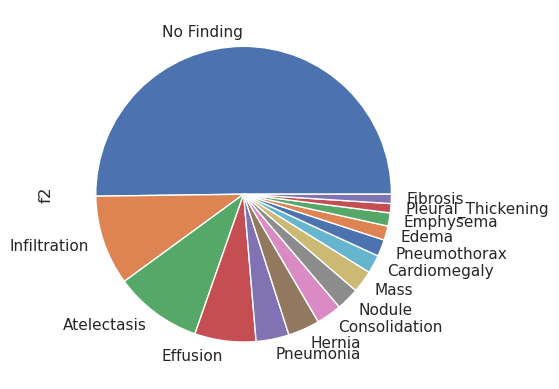

In [48]:
new_df_gan['f2'].value_counts().plot(kind="pie")

In [24]:
model = tf.keras.applications.densenet.DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=15,
    classifier_activation='softmax'
)


In [32]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the data into a Pandas dataframe

# Separate the features and target variable
X = new_df_gan['FilePath']
y = new_df_gan['f2']

# Perform stratified train-test split with 70% training data and 30% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [33]:
test_df1 = pd.DataFrame({'FilePath':X_test,'f2':y_test})

In [34]:
# apply one-hot encoding
one_hot = pd.get_dummies(test_df1['f2'])

# add the one-hot encoded columns to the original dataframe
test_df1 = pd.concat([test_df1, one_hot], axis=1)

test_df1.drop(['f2','No Finding'],axis=1,inplace=True)

In [36]:
test_df1.shape

(35959, 15)

In [37]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input

datagen = ImageDataGenerator()

batch_size = 32
test_generator = datagen.flow_from_dataframe(
dataframe = test_df1,
x_col = 'FilePath',
y_col = labels,
target_size = (224,224),
batch_size = batch_size,
class_mode = 'raw',
shuffle = True)

Found 35959 validated image filenames.


In [26]:
new_df1_gan = pd.DataFrame({'FilePath':X_train,'f2':y_train})

In [27]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input

datagen = ImageDataGenerator()

batch_size = 32
generator = datagen.flow_from_dataframe(
dataframe = new_df1_gan,
x_col = 'FilePath',
y_col = 'f2',
target_size = (224,224),
batch_size = batch_size,
class_mode = 'categorical',
shuffle = True)

Found 83904 validated image filenames belonging to 15 classes.


In [28]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])


In [29]:
num_epochs = 5
step_per_epoch = len(new_df1_gan)//batch_size
history = model.fit_generator(
generator = generator,
steps_per_epoch = step_per_epoch,
epochs = num_epochs)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
2622/2622 [==============================] - 2171s 803ms/step - loss: 1.5934 - accuracy: 0.5565
Epoch 2/5
2622/2622 [==============================] - 1955s 746ms/step - loss: 1.5506 - accuracy: 0.5454
Epoch 3/5
2622/2622 [==============================] - 1964s 749ms/step - loss: 1.4751 - accuracy: 0.5693
Epoch 4/5
2622/2622 [==============================] - 1908s 728ms/step - loss: 1.4329 - accuracy: 0.5745
Epoch 5/5
2622/2622 [==============================] - 1847s 704ms/step - loss: 1.4101 - accuracy: 0.5765


In [31]:
model.save_weights('densenet_weights.hdf5')

In [38]:
predicted_vals = model.predict(test_generator, steps = len(test_generator), verbose = 1)

1124/1124 [==============================] - 807s 716ms/step


In [39]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)
#The random.seed() function is a method in Python's random module that initializes the random number generator with a given seed value. 
#It allows you to generate a sequence of random numbers that can be replicated or reproduced in future runs, as long as the same seed value is used.


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    optimal_thresholds = []
    sensitivity = []
    specificity = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i] 
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred) # return 
            auc_roc_vals.append(auc_roc)
            fpr, tpr, thresholds = roc_curve(gt, pred)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            y_pred = pred > optimal_threshold
            acc = accuracy_score(gt, y_pred)
            prec = precision_score(gt, y_pred)
            rec = recall_score(gt, y_pred)
            f1_s = f1_score(gt, y_pred)
            accuracy.append(acc)
            precision.append(prec)
            recall.append(rec)
            f1.append(f1_s)
            optimal_thresholds.append(optimal_threshold) # find optimal thresholds https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve
            optimal_tpr = round(tpr[optimal_idx],3)
            optimal_1_fpr = round(1 - fpr[optimal_idx],3)
#             print(f"Length of tpr tpr : {len(tpr)} \n Length of thresholds {len(thresholds)}")
#             print(f"optimal index : {optimal_idx} \n Optimal 1 - fpr : {optimal_1_fpr}")
            sensitivity.append(optimal_tpr)
            specificity.append(1-fpr[optimal_idx])
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--') # black dash line
            plt.plot(fpr, tpr,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals, optimal_thresholds, sensitivity, specificity, accuracy, precision, recall, f1

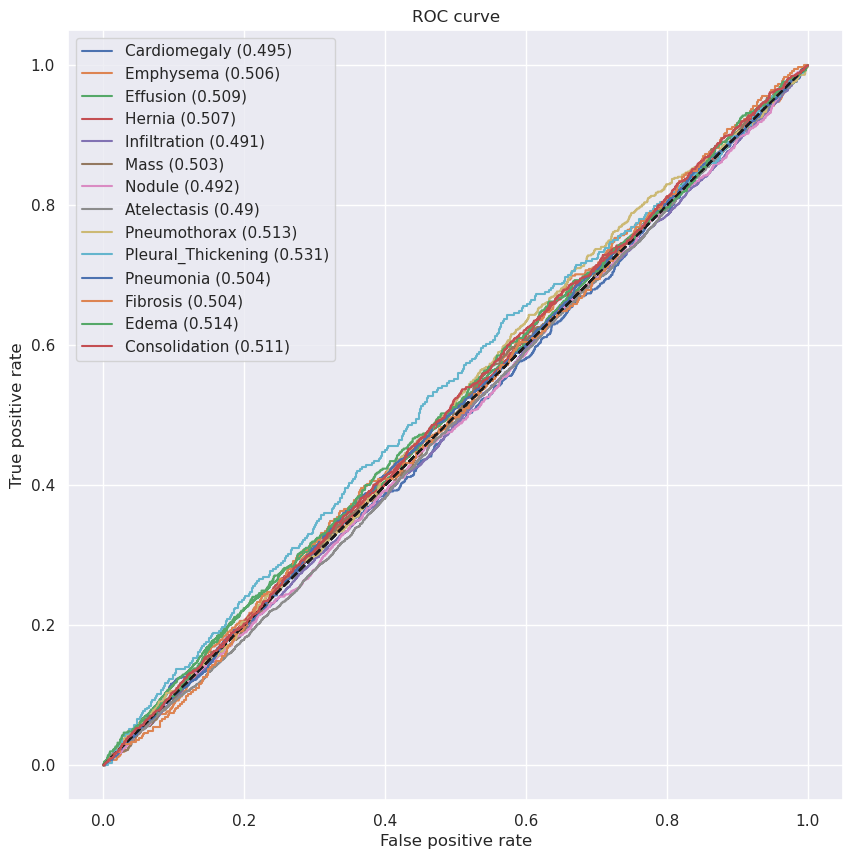

In [40]:
# get roc curve
from statistics import mean
auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1 = get_roc_curve(labels, predicted_vals, test_generator)

In [41]:
from tabulate import tabulate
table = zip(labels, auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1)
print(tabulate(table, headers = ['Pathology', 'AUC', 'Threshold Value', 'Sensitivity', 'Specificity', 'Accuracy', 'Precision', 'Recall', 'F1 Score'], tablefmt = 'fancy_grid'))

╒════════════════════╤══════════╤═══════════════════╤═══════════════╤═══════════════╤════════════╤═════════════╤═══════════╤════════════╕
│ Pathology          │      AUC │   Threshold Value │   Sensitivity │   Specificity │   Accuracy │   Precision │    Recall │   F1 Score │
╞════════════════════╪══════════╪═══════════════════╪═══════════════╪═══════════════╪════════════╪═════════════╪═══════════╪════════════╡
│ Cardiomegaly       │ 0.494855 │        0.343657   │         0.117 │      0.903911 │   0.888095 │   0.0239262 │ 0.115118  │  0.0396181 │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼───────────┼────────────┤
│ Emphysema          │ 0.505611 │        0.0116233  │         0.699 │      0.335638 │   0.34086  │   0.015142  │ 0.697495  │  0.0296405 │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼───────────┼────────────┤
│ Effusion           │ 0.509377 │ 

In [53]:
data = image_label_map[labels].sum(axis=0).sort_values(ascending = True)
data

Hernia                  227
Pneumonia              1429
Fibrosis               1683
Edema                  2296
Emphysema              2511
Cardiomegaly           2775
Pleural_Thickening     3379
Consolidation          4660
Pneumothorax           5293
Mass                   5772
Nodule                 6318
Atelectasis           11543
Effusion              13287
Infiltration          19869
dtype: int64

In [61]:
data = image_label_map[labels].sum(axis=0).sort_values(ascending = True)

# bokeh packages

diagnosis = data.index.tolist()
source = ColumnDataSource(data=dict(diagnosis=data.index.tolist(), counts=data.tolist(), color = Category20b[len(data)]))

tooltips = [("Diagnosis", "@diagnosis"), ("Count", "@counts") ]
diag_dist = figure(x_range=diagnosis, y_range=(0,15000), plot_height=400, plot_width = 700, title="Diagnosis Distributions", tooltips = tooltips)
diag_dist.vbar(x='diagnosis', top='counts', width=0.65, color='color', legend_field="diagnosis", source=source)

diag_dist.xgrid.grid_line_color = None
diag_dist.legend.orientation = "vertical"
diag_dist.legend.location = "top_left"

# show(diag_dist)




def plot_pie_bokeh(data = None):
    from math import pi
    from bokeh.palettes import Category20c
    x = data.to_dict()

    data = pd.Series(x).reset_index(name='value').rename(columns={'index':'category'})
    data['angle'] = data['value']/data['value'].sum() * 2*pi
    data['color'] = Category20b[len(x)]
    p = figure(plot_height=400, plot_width = 700, title="Pie Chart", tooltips="@category: @value%", x_range=(-0.5, 1.0))
    p.wedge(x=0.38, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="black", fill_color='color', legend_field='category', source=data)

    p.axis.axis_label=None
    p.axis.visible=False
    p.grid.grid_line_color = None

    p.legend.orientation = "vertical"
    p.legend.location = "top_left"
    
    return p


dist_diag_percent = plot_pie_bokeh(data/data.sum()*100)

show(column(diag_dist, dist_diag_percent))

In [59]:
show(plot_pie_bokeh(data/data.sum()*100))